# Thermal shift assay

## __<font color=blue>Introduction</font>__
---

In a __Thermal Shift Assay (TSA)__, we use a protein-binding dye, such as SYPRO® Orange (Molecular Probes), and a real-time PCR system, such as the LightCycler® 480 Instrument II (Roche), to measure __a protein melting curve__ (_i.e._ a fluorescence versus temperature plot). Basically, when the protein unfolds due to an increase in temperature, the dye binds to its exposed hydrophobic residues. This results in an increase in fluorescence. A typical result is shown below:

```{image} ./Images/ThermalShiftAssayPrinciple.png
:alt: Principle behind thermal shift assay
:width: 600px
:align: center
```

These melting curves can be used to calculate __the protein's melting temperature, _i.e._ $T_m$__, for each test buffer. Changes in $T_m$ are related to changes in protein stability.

This notebook shows you how to analyze protein melting curves generated by the LightCycler® 480 Instrument II using _Python_.

## __<font color=blue>Data</font>__
---

Get the data needed for this exercise [here](https://github.com/renee-85/PythonForBIOC0029/tree/master/data).

The data we will analyze are from an optimization run to determine the optimal protein and dye concentrations for the TSA.
- __Protein__: T4 Lysozyme WT* (_i.e._ C54T/C97A)
- __Protein storage buffer__: 50 mM sodium phosphate, 2 mM ethylenediamine tetra-acetic acid, 350 mM NaCl, pH 6.5
- __Dye__: SYPRO® Orange (Thermo Scientific)
- __Assay buffer__: 1 x PBS (Lonza), pH 7.41
- __Sample volume__: 20 µl
- __Protein concentration__: 8, 4, 2, and 1 µM
- __Dye concentration__: 5, 6.67, 10 and 20 x
- __Data acquisition__:
    - Excitation: 465nm
    - Emission: 580nm
    - Temperature: 20-85°C, in smooth ramp mode, rate of 0.06°C $s^{-1}$
- __Plate__: LightCycler® 480 multi-well plate 96, white (Roche) with sealing foil

The  fluorescence measured at 580 nm after excitation at 465 nm as a function of temperature (from 20 to 85°C) is in A1 to D4. The figure below explains the 96-well plate lay-out:

```{image} ./Images/ThermalShiftAssayPlate.png
:alt: Plate set-up for the thermal shift assay
:width: 600px
:align: center
```

## __<font color=blue>Import the libraries needed</font>__
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d # to smoothen data, see the tip below
from scipy.signal import savgol_filter # to smoothen data, see the tip below

## __<font color=blue>For well A1</font>__
---

### __<font color=red>Read the data from the file and select well A1</font>__

The data file contains a header with the experiment name, and 8 columns. We only read in columns 1, 2, 7 and 8, _i.e._ the sample position, the sample name, the temperature and the fluorescence signal. This is demonstrated in the figure below:

```{image} ./Images/ThermalShiftAssayTxtFile.png
:alt: Principle behind thermal shift assay
:width: 600px
:align: center
```

In [2]:
df = pd.read_csv('../data/ThermalShiftAssay.txt', skiprows=1, sep='\t', usecols=[0, 1, 6, 7])
# We use pd.read_csv to read in the file and store the information in a new dataframe, i.e. df.
# We use skiprows=1 to skip the first row.
# We use sep='\t' to specify that we have a tab-delimited text format.
# We use usecols=[0, 1, 6, 7] to only read in columns 1, 2, 7, and 8.
print(df)

      SamplePos  SampleName   Temp  465-580
0            A1  T4L wt 8uM  20.01     6.94
1            A1  T4L wt 8uM  20.01     6.99
2            A1  T4L wt 8uM  20.16     6.97
3            A1  T4L wt 8uM  20.32     7.00
4            A1  T4L wt 8uM  20.40     6.96
...         ...         ...    ...      ...
61915       H12       Empty  84.47     4.32
61916       H12       Empty  84.59     4.35
61917       H12       Empty  84.67     4.34
61918       H12       Empty  84.76     4.35
61919       H12       Empty  84.88     4.33

[61920 rows x 4 columns]


In [3]:
dfa1 = df[df['SamplePos']=='A1']
# We select all rows that contain A1 as sample position and store them in a new dataframe, i.e. dfa1.
print(dfa1)

    SamplePos  SampleName   Temp  465-580
0          A1  T4L wt 8uM  20.01     6.94
1          A1  T4L wt 8uM  20.01     6.99
2          A1  T4L wt 8uM  20.16     6.97
3          A1  T4L wt 8uM  20.32     7.00
4          A1  T4L wt 8uM  20.40     6.96
..        ...         ...    ...      ...
640        A1  T4L wt 8uM  84.47    78.21
641        A1  T4L wt 8uM  84.59    77.87
642        A1  T4L wt 8uM  84.67    77.57
643        A1  T4L wt 8uM  84.76    77.29
644        A1  T4L wt 8uM  84.88    76.92

[645 rows x 4 columns]


### __<font color=red>Plot "fluorescence (= $y$) versus temperature (= $x$)" data from well A1</font>__

We plot fluorescence versus temperature. We need to convert the temperature from &deg;C to &deg;K.

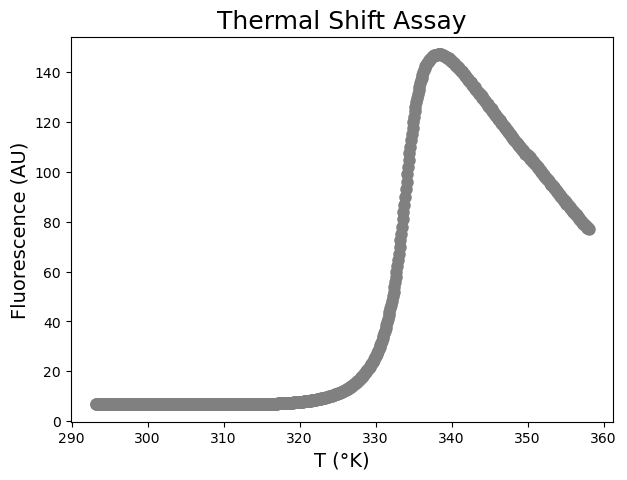

In [4]:
xdfa1=dfa1['Temp'] + 273.15
# We select the temperature = x and convert it from °C to °K, the result is stored in a new dataframe, i.e. xdfa1.

ydfa1=dfa1['465-580']
# We select the fluorescence signal = y, the result is stored in a new dataframe, i.e. ydfa1.

# We now plot the graph "fluorescence signal" versus "temperature".
plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

We see the typical sigmoidal transition.

There are multiple ways to extract $T_m$ (= the midpoint of the transition = the inflection point of the sigmoidal curve):
- The first derivative method
- Curve-fitting methods. A sigmoidal function is used to fit the protein melting curve. Curve-fitting methods are known to be more robust and less sensitive to random noise than the first-derivative method. Multiple functions are used: 
   - A Boltzmann model
   - The equation describing the unfolding of a monomer via a two-state mechanism

The difference between both methods is demonstrated in the figure below:

```{image} ./Images/ThermalShiftAssayAnalysis.png
:alt: Analysing the thermal shift assay
:width: 600px
:align: center
```

### __<font color=red>Analysis: 1. First derivative method</font>__

The first derivative of a function is the slope of the tangent line for any point on the function. It informs us when the function is increasing, decreasing, or constant.

A sigmoidal function has a bell-shaped first derivative. At the inflection point of the sigmoidal curve, the tangent has the steepest slope and the first derivative has its maximum.

The first-derivative method determines the midpoint of the transition (= the inflection point of the sigmoidal curve = $T_m$) by searching for the peak of the first-derivative curve.

In the following calculations, we work with Numpy arrays. To see why, try the following command and look at both outputs:

In [5]:
print(np.array(xdfa1))
print(xdfa1)

[293.16 293.16 293.31 293.47 293.55 293.69 293.84 293.92 294.08 294.08
 294.23 294.31 294.38 294.52 294.6  294.68 294.83 294.91 295.05 295.12
 295.19 295.34 295.41 295.49 295.56 295.7  295.84 295.91 295.98 296.05
 296.2  296.27 296.34 296.49 296.56 296.68 296.75 296.83 296.96 297.03
 297.18 297.24 297.31 297.44 297.51 297.58 297.71 297.78 297.92 298.05
 298.11 298.18 298.38 298.44 298.51 298.64 298.71 298.83 298.9  299.02
 299.16 299.22 299.35 299.48 299.55 299.6  299.79 299.92 299.98 300.1
 300.17 300.3  300.41 300.48 300.54 300.66 300.78 300.91 301.03 301.09
 301.2  301.32 301.45 301.51 301.63 301.68 301.8  301.92 302.03 302.1
 302.15 302.33 302.45 302.51 302.55 302.68 302.85 302.91 303.03 303.08
 303.2  303.36 303.47 303.59 303.59 303.7  303.81 303.92 304.02 304.14
 304.25 304.36 304.42 304.53 304.64 304.74 304.85 304.96 305.07 305.12
 305.28 305.39 305.45 305.54 305.65 305.76 305.87 305.92 306.02 306.13
 306.22 306.34 306.44 306.54 306.64 306.75 306.85 306.94 307.05 307.15
 307.25 

The essential difference is the presence of the index: while the Numpy array has an implicitly defined integer index used to access the values, the Pandas series has an explicitly defined index associated with the values.

To calculate the derivative of our fluorescence (= $y$) versus temperature (= $x$) data, we subtract two adjacent elements in $y$, and divide by the difference in the two corresponding elements in $x$. This is represented with the following formula:

$$
\frac{dy}{dx} = \frac{y_2 - y_1}{x_2 - x_1} .
$$

Note that this _approximated derivative_ has size $n-1$ with $n$ being our amount of data points.

We use the [numpy.diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) and [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) functions.

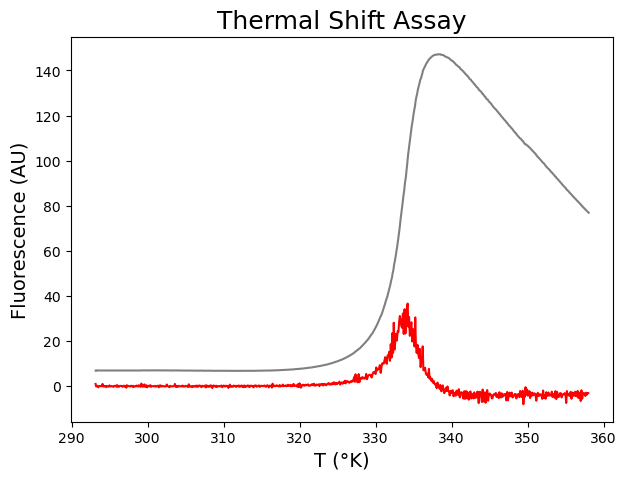

In [6]:
outa1 = np.ones( (len(np.array(ydfa1)) -1) )
derya1 = np.divide(np.diff(np.array(ydfa1)), np.diff(np.array(xdfa1)), out=outa1, where=np.diff(np.array(xdfa1))!=0)
# The np.diff function calculates the n-th discrete difference. When n = 1 (default), np.diff calculates the difference between subsequent elements in our array, and returns an array that is one element shorter. 
# The np.divide function returns a division of the inputs. To prevent division by zero, we can take advantage of the "where" option.
# We pre-initialize the output 'outa1' that we will use when the "divide by zero encountered" error happens. The input of 'out=' needs to be an array.
# To create the array 'outa1', we use the np.ones function which returns an array of given shape (i.e. n-1 data points, the 'len()' function gives us n) and type, filled with ones.

derxa1 = (np.array(xdfa1)[:-1] + np.array(xdfa1)[1:]) / 2
# The derivative is of size n-1, and is evaluated at the midpoints. The x data for the derivative can be calculated via (all but the last elements of x (represented by x[:-1]) + all but the first element of x (represented by x[1:])) / 2.

# We now plot the graph "fluorescence signal" versus "temperature" and add the calculated first derivative to it.
plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, color='gray')
plt.plot(derxa1, derya1, color='red')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

Ok, but I want to _pimp my graph_ by (1) using a secondary Y-axis and (2) smoothing the first derivative curve.

#### __Tip: How to make a plot with a secondary Y-axis?__

A secondary Y-axis is a Y-axis drawn on the right-hand side of the graph. The primary Y-axis is on the left-hand side of the graph. You can use a secondary Y-axis with a different scale than the primary Y-axis to plot a series of data on a different scale. This lets you compare two series of data more easily on the same graph.

Use the [matplotlib.pyplot.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) and the [matplotlib.axes.Axes.twinx](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html) functions to create a secondary Y-axis.

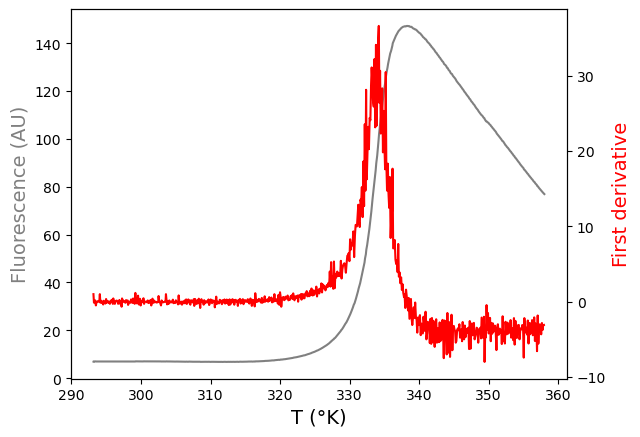

In [7]:
fig,ax = plt.subplots()
# create figure and axis objects with subplots()

ax.plot(xdfa1, ydfa1, color='gray')
# make a plot

ax.set_xlabel('T (°K)', fontsize=14)
ax.set_ylabel('Fluorescence (AU)',color="gray",fontsize=14)
# set x- and y-axis labels

ax2=ax.twinx()
# instantiate a second axes that shares the same x-axis

ax2.plot(derxa1, derya1, color='red')
# make a plot with different y-axis using second axis object

ax2.set_ylabel('First derivative',color="red",fontsize=14)
# set y-axis label for the second axis object

plt.show()

#### __Tip: How to smoothen a curve?__

Smoothing is usually done to help us see patterns in data series. We smooth out the _roughness_ to see a clearer signal. How? The data points are modified so that points higher than the adjacent points (presumably because of noise) are reduced, and points lower than the adjacent points (presumably because of noise) are increased.

You can smooth data several ways in _Python_. Have a look at the [scipy.ndimage.uniform_filter1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html) function for a moving average filter and the [scipy.signal.savgol_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) function for a Savitzky-Golay filter.

A __moving average filter__ is the simplest filter to understand and use. It is commonly used to smooth out short-term fluctuations. For example, using a filer of length 3, the _new, smoothed_ point $x$ is the average of the _old_ points $x-1$, $x$, and $x+1$.

A __Savitzky-Golay filter__ uses least squares to regress a small window of the data onto a polynomial, then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward by one data point and the process repeats. This continues until every point has been optimally adjusted relative to its neighbours. 

The example below shows the difference between both methods:

In [8]:
xtestsmooth = [0,1,2,3,4,5,6,7,8]
ytestsmooth = [2, 2, 5, 2, 1, 0, 1, 4, 9]

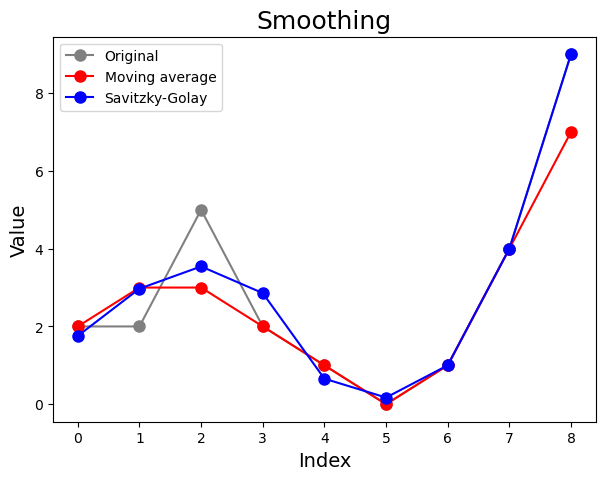

In [9]:
plt.figure(figsize=(7,5))
plt.plot(xtestsmooth, ytestsmooth, '-o', color='gray', markersize=8, label='Original')
plt.plot(xtestsmooth, uniform_filter1d(ytestsmooth, size=3), '-o', color='red', markersize=8, label='Moving average') # length of filter is 3
plt.plot(xtestsmooth, savgol_filter(ytestsmooth, 5, 3), '-o', color='blue', markersize=8, label='Savitzky-Golay') # window size is 5, polynomial order is 3
plt.title('Smoothing', fontsize=18)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(loc='upper left')
plt.show()

A Saviztky-Golay filter is often better than a moving average filter because it tends to preserve features of the data which are usually attenuated by a moving average filter, _i.e._ area, position and width of peaks. A moving average filter can produce significant distortions and reduce the signal intensity, with the subsequent loss of adjacent small signals. Off course, all depends on the filter size, window size and polynomial order used.

Back to our data, now with a secondary Y-axis and a smooth first derivative:

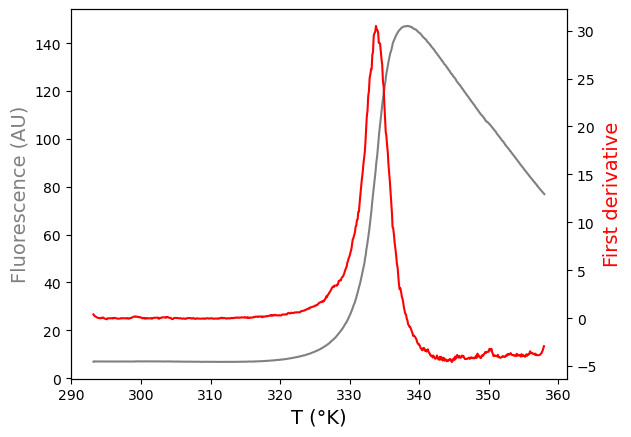

In [10]:
fig,ax = plt.subplots()
ax.plot(xdfa1, ydfa1, color='gray')
ax.set_xlabel('T (°K)', fontsize=14)
ax.set_ylabel('Fluorescence (AU)',color="gray",fontsize=14)
ax2=ax.twinx()
ax2.plot(derxa1, savgol_filter(derya1, 21, 3), color='red')
ax2.set_ylabel('First derivative',color="red",fontsize=14)
plt.show()

That looks much better!

We now need to find the y-value for the peak in the first derivative signal (_i.e._ the maximum value) and its corresponding x-value, which is the $T_m$ we are looking for.

In [11]:
max_derya1 = np.max(derya1)
# find the maximum y value

max_derxa1 = derxa1[derya1.argmax()] 
# find the x value corresponding to the maximum y value

print(max_derxa1, max_derya1)

334.21 36.62499999998117


The $T_m$ is 334 °K.

### __<font color=red>Analysis: 2. Curve-fitting using a Boltzmann model</font>__

Using the Boltzmann equation:

$$
Y = Y_{min} + \frac{(Y_{max} - Y_{min})}{1 + exp (\frac{T_m - T}{a})}
$$

where $Y$ is the observed fluorescence intensity, $Y_{min}$ and $Y_{max}$ are pretransitional and posttransitional fluorescence intensities, and $a$ is a slope factor. $T$ is the temperature and $T_m$ is the midpoint of the thermal unfolding curve.

In [12]:
# We define the function to fit the data.
def funcBoltzmann(x, Ymin, Ymax, Tm, a):
    
    return Ymin + ((Ymax) - Ymin)/(1 + np.exp((Tm-x)/a))

We test input parameters for [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) based on visual inspection (see figure below), this involves trial and error.

```{image} ./Images/ThermalShiftAssayParametersBoltzmann.png
:alt: Analysing the thermal shift assay
:width: 600px
:align: center
```

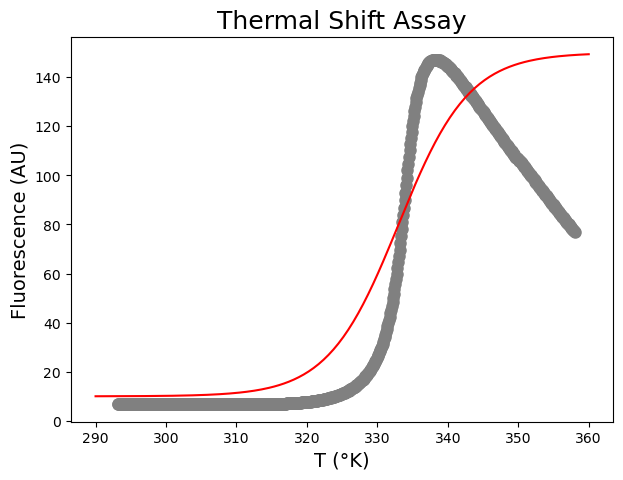

In [13]:
# We plot our curve with initial guesses for the parameters onto the data. Change these guesses if needed.
# Note that we first create a list of temperatures as input for our function using the numpy.linspace command.

xin = np.linspace(290, 360, 200)

plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcBoltzmann(xin, 10, 150, 333, 5), color="red",label='Guess')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

Looks ok. We can now run [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and plot the resulting curve on the data.

[  8.46641251 117.38342176 332.50319245   0.96940869]
[0.72752489 0.92834356 0.10142863 0.08840673]


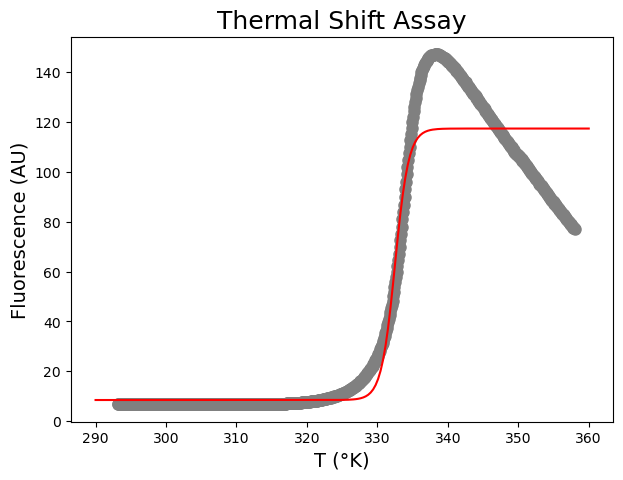

In [14]:
# We fit the data.
paramsBoltzmann, params_covarianceBoltzmann = curve_fit(funcBoltzmann, xdfa1, ydfa1,
                                               [ 10, 150, 333, 5], maxfev=10000)

# We print the fitted parameters.
print(paramsBoltzmann)
print(np.sqrt(np.diag(params_covarianceBoltzmann)))

# We plot the fitted curve onto the data.
plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcBoltzmann(xin, *paramsBoltzmann), color="red",label='Fit')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

This does not look good! The Boltzmann function does not take post-peak fluorescence into account, often observed in TSAs due to protein aggregation and dye dissociation at higher temperatures. We can include an empirical term to model fluorescence decrease with temperature after peak fluorescence:

$$
Y = Y_{min} + \frac{(Y_{max} - b(T - T_m) - Y_{min})}{1 + exp (\frac{T_m - T}{a})}
$$

where $Y$ is the observed fluorescence intensity, $Y_{min}$ and $Y_{max}$ are pretransitional and posttransitional fluorescence intensities, $a$ is a slope factor for the transition, and $b$ accounts for the decrease in $Y$ after peak fluorescence. $T$ is the temperature and $T_m$ is the midpoint of the thermal unfolding curve.

As this is an empirical model, multiple options to include fluorescence decrease with temperature after peak fluorescence are possible!

Let's see if this works:

[  7.85990258 171.68481688 333.74524363   1.52565204   3.97356596]
[0.09701873 0.33837075 0.01447148 0.0111816  0.0236133 ]


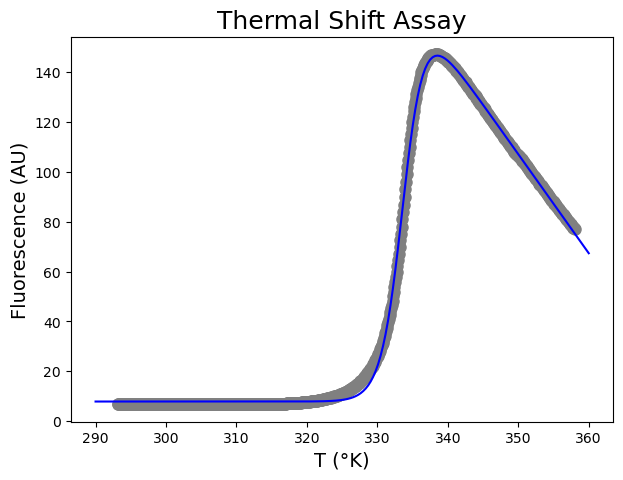

In [15]:
# We define the new function.
def funcBoltzmannEmpirical(x, Ymin, Ymax, Tm, a, b):
    
    return Ymin + ((Ymax - b*(x - Tm) - Ymin)/(1 + np.exp((Tm-x)/a)))

# We fit the data.
paramsBoltzmannEmpirical, params_covarianceBoltzmannEmpirical = curve_fit(funcBoltzmannEmpirical, xdfa1, ydfa1,
                                               [10, 150, 333, 5, 2], maxfev=10000)
# We print the fitted parameters.
print(paramsBoltzmannEmpirical)
print(np.sqrt(np.diag(params_covarianceBoltzmannEmpirical)))

# We plot the fitted curve onto the data.
plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcBoltzmannEmpirical(xin, *paramsBoltzmannEmpirical), color="blue",label='Fit')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

The $T_m$ is 333.75 $\pm$ 0.01 °K.

### __<font color=red>Analysis: 3. Curve-fitting using the equation describing the unfolding of a monomer via a two-state mechanism</font>__

Using the equation describing the unfolding of a monomer via a two-state mechanism:

$$
Y = \frac{(Y_{n'} + m_n T) + (Y_{u'} + m_u T)  \exp (\frac{\Delta H_m (\frac{T}{T_m} - 1) + \Delta C_p (T_m - T + T ln (\frac{T}{T_m}))}{RT})}
{1 + \exp (\frac{\Delta H_m (\frac{T}{T_m} - 1) + \Delta C_p (T_m - T + T ln (\frac{T}{T_m}))}{RT})} .
$$

where $Y$ is the observed fluorescence intensity, $m_n$ and $m_u$ account for changes in the signals of the pre- and post-transition regions with changes in temperature and $Y_{n'}$ and $Y_{u'}$ are the signal of the native and unfolded states. $T$ is the temperature, $T_m$ is the midpoint of the thermal unfolding curve, $\Delta H_m$ is the enthalpy change for protein unfolding at $T_m$ and $\Delta C_p$ is the change in heat capacity.

In [16]:
def funcUF(x, yn, mn, yu, mu, DHm, Tm, DCp):
    
    return ((yn + mn * x) + (yu + mu * x) * np.exp((DHm * ((x / Tm) - 1) + DCp * (Tm - x + x * np.log(x / Tm))) / (8.314 * x))) / (1 + np.exp((DHm * ((x / Tm) - 1) + DCp * (Tm - x + x * np.log(x / Tm))) / (8.314 * x)))

First, test input parameters for [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) based on visual inspection. I usually start with a $\Delta H_m$-value around 300 kJ mol$^{-1}$ and a $\Delta C_p$-value around 10 kJ mol$^{−1}$ K$^{-1}$. Finding good guesses involves trial and error, I included my final result.

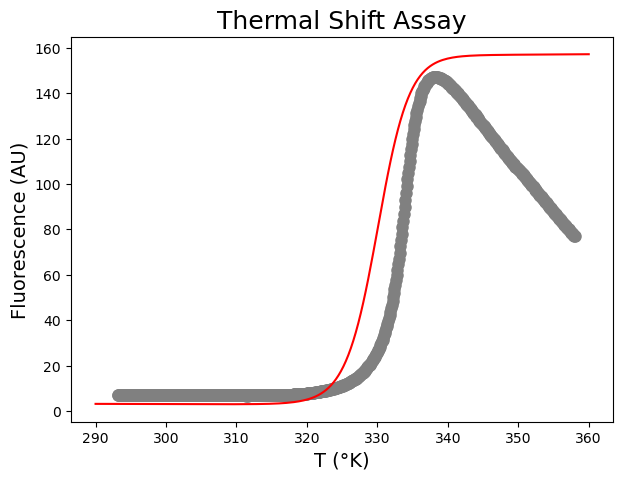

In [17]:
plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcUF(xin, 6, -0.01, 150, 0.02, 402000, 330, 6000), color="red",label='Fit')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

Second, run [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and plot the resulting curve on the data.

[-3.60741800e+01  1.40218168e-01  1.46004700e+03 -3.86614730e+00
  6.48921008e+05  3.33813581e+02  2.63591358e+04]
[2.16781537e+00 6.94593293e-03 4.86727186e+00 1.39736487e-02
 3.32159245e+03 9.06504468e-03 2.19021576e+02]


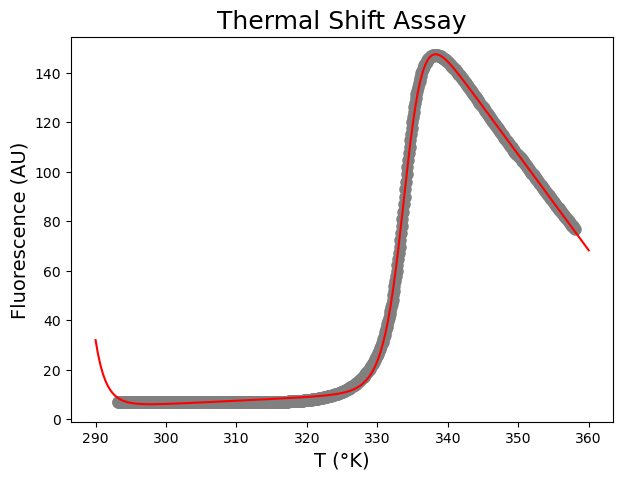

In [18]:
paramsUF, params_covarianceUF = curve_fit(funcUF, xdfa1, ydfa1,
                                               [6, -0.01, 150, 0.02, 402000, 330, 6000], maxfev=10000)

print(paramsUF)
print(np.sqrt(np.diag(params_covarianceUF)))

plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcUF(xin, *paramsUF), color="red",label='Fit')
plt.title('Thermal Shift Assay', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('Fluorescence (AU)', fontsize=14)
plt.show()

From this fit, we can conclude that $\Delta H_m$ is 649 $\pm$ 3 kJ mol$^{-1}$ K$^{-1}$, $\Delta C_p$ 26.4 $\pm$ 0.2 kJ mol$^{−1}$ K$^{-1}$ and that $T_m$ is 333.81 $\pm$ 0.01 K.

#### __Advice: Overfitting__

Overfitting happens when the model is too complex for the data. In our case, can we justify the use of all parameters? 

When the enthalpy and entropy are temperature independent, we can write:

$$
Y = \frac{(Y_{n'} + m_n T) + (Y_{u'} + m_u T)  \exp(\frac{\Delta H_m}{R} (\frac{1}{T_m} - \frac{1}{T}))}
{1 + \exp(\frac{\Delta H_m}{R} (\frac{1}{T_m} - \frac{1}{T}))} ,
$$

Now we only have 6 variables... Let us see if that works:

In [19]:
def funcUFnoDCp(x, yn, mn, yu, mu, DHm, Tm):
    
    return ((yn + mn * x) + (yu + mu * x) * np.exp((DHm / 8.314) * ((1 / Tm) - (1 / x)))) / (1 + np.exp((DHm / 8.314) * ((1 / Tm) - (1 / x))))


[-3.87419869e+01  1.50303538e-01  1.48440857e+03 -3.93535895e+00
  6.41886743e+05  3.33812832e+02]
[2.47012998e+00 7.94675118e-03 6.88836674e+00 1.97610448e-02
 4.46184075e+03 1.24515726e-02]


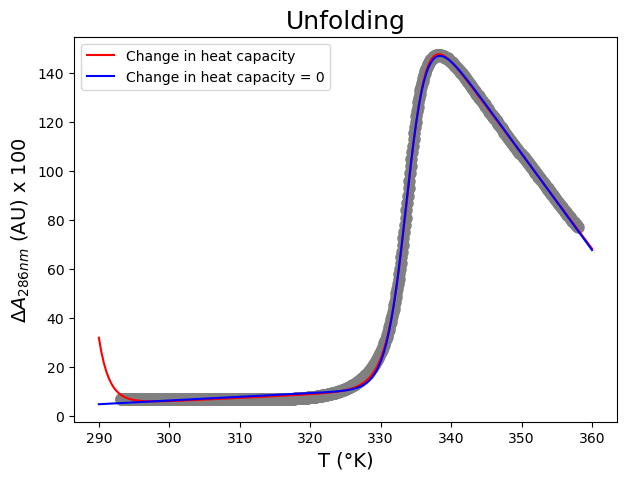

In [32]:
paramsUFnoDCp, params_covarianceUFnoDCp = curve_fit(funcUFnoDCp, xdfa1, ydfa1,
                                               [6, -0.01, 150, 0.02, 402000, 330], maxfev=10000)

print(paramsUFnoDCp)
print(np.sqrt(np.diag(params_covarianceUFnoDCp)))

plt.figure(figsize=(7,5))
plt.plot(xdfa1, ydfa1, 'o', color='gray', markersize=8)
plt.plot(xin, funcUF(xin, *paramsUF), color="red",label='Change in heat capacity')
plt.plot(xin, funcUFnoDCp(xin, *paramsUFnoDCp), color="blue",label='Change in heat capacity = 0')
plt.title('Unfolding', fontsize=18)
plt.xlabel('T (°K)', fontsize=14)
plt.ylabel('$\Delta$$A_{286nm}$ (AU) x 100', fontsize=14)
plt.legend(loc='upper left')
plt.show()

From this fit, we can conclude that $\Delta H_m$ is 642 $\pm$ 4 kJ mol$^{-1}$ K$^{-1}$ and that $T_m$ is 333.81 $\pm$ 0.01 K. Very similar to the previous fit...

## __<font color=blue>And now for each well...</font>__
---

Let's have a look at all wells. We first group by SamplePos column and convert its result into a dictionary of DataFrames. More information on dictionaries and tuples in _Python_ is available [here](https://problemsolvingwithpython.com/04-Data-Types-and-Variables/04.05-Dictionaries-and-Tuples/).

In [21]:
dict_of_wells = dict(tuple(df.groupby("SamplePos")))
# We group by SamplePos column and convert its result into a dictionary of DataFrames.
print(dict_of_wells)

{'A1':     SamplePos  SampleName   Temp  465-580
0          A1  T4L wt 8uM  20.01     6.94
1          A1  T4L wt 8uM  20.01     6.99
2          A1  T4L wt 8uM  20.16     6.97
3          A1  T4L wt 8uM  20.32     7.00
4          A1  T4L wt 8uM  20.40     6.96
..        ...         ...    ...      ...
640        A1  T4L wt 8uM  84.47    78.21
641        A1  T4L wt 8uM  84.59    77.87
642        A1  T4L wt 8uM  84.67    77.57
643        A1  T4L wt 8uM  84.76    77.29
644        A1  T4L wt 8uM  84.88    76.92

[645 rows x 4 columns], 'A10':      SamplePos SampleName   Temp  465-580
5805       A10      Empty  20.01     5.22
5806       A10      Empty  20.01     5.23
5807       A10      Empty  20.16     5.20
5808       A10      Empty  20.32     5.19
5809       A10      Empty  20.40     5.20
...        ...        ...    ...      ...
6445       A10      Empty  84.47     3.11
6446       A10      Empty  84.59     3.13
6447       A10      Empty  84.67     3.12
6448       A10      Empty  84.76     

We now plot the raw data for each well of the plate. We use the [matplotlib.gridspec.GridSpec](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html#matplotlib.gridspec.GridSpec) function to make a grid of plots. This takes a while.

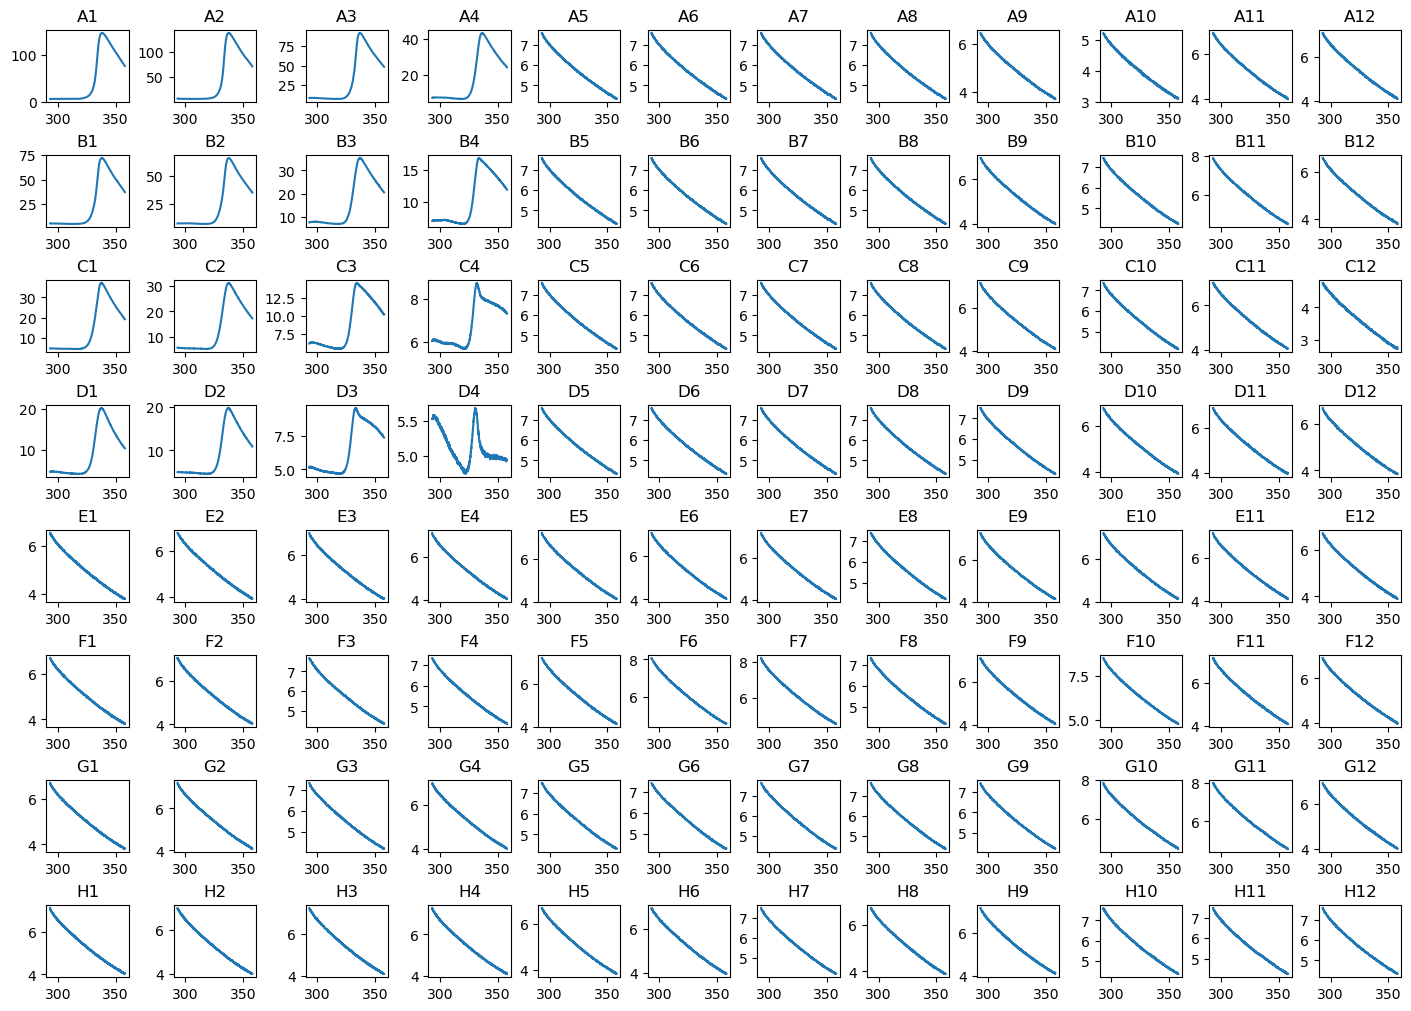

In [22]:
WellsAll96=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12']

fig = plt.figure(figsize=(14,10), constrained_layout=True)
# We create a figure object. If we don't use constrained_layout, then labels overlap the axes.

gs1 = fig.add_gridspec(8, 12)
# We use gridspec to create grid-shaped combinations of graphs. P.S. an alternative is to use subplots.
# The number of rows (in our case 8) and number of columns (in our case 12) of the grid need to be set.

axs = []

for i, num in zip(WellsAll96, range(1,97)):
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].plot(dict_of_wells[i]['Temp'] + 273.15, dict_of_wells[i]['465-580'])
    axs[-1].set_title(i)
    # We loop over all wells i using for. We have 96 wells, hence range(1,97).
    # We append each plot to the grid previously created. The title of each plot is the name of the well, e.g. A1, A2.
   
plt.show()

Let's now fit all data corresponding to T4 Lysozyme WT* (_i.e._ A1 to D4, the other wells are empty) using the equation describing the unfolding of a monomer via a two-state mechanism but with temperature-independent enthalpy and entropy. We do first create an empty DataFrame with only column names, we will store the fitted melting temperatures in this DataFrame. We use the [pandas.concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) function in the loop to add rows to it.

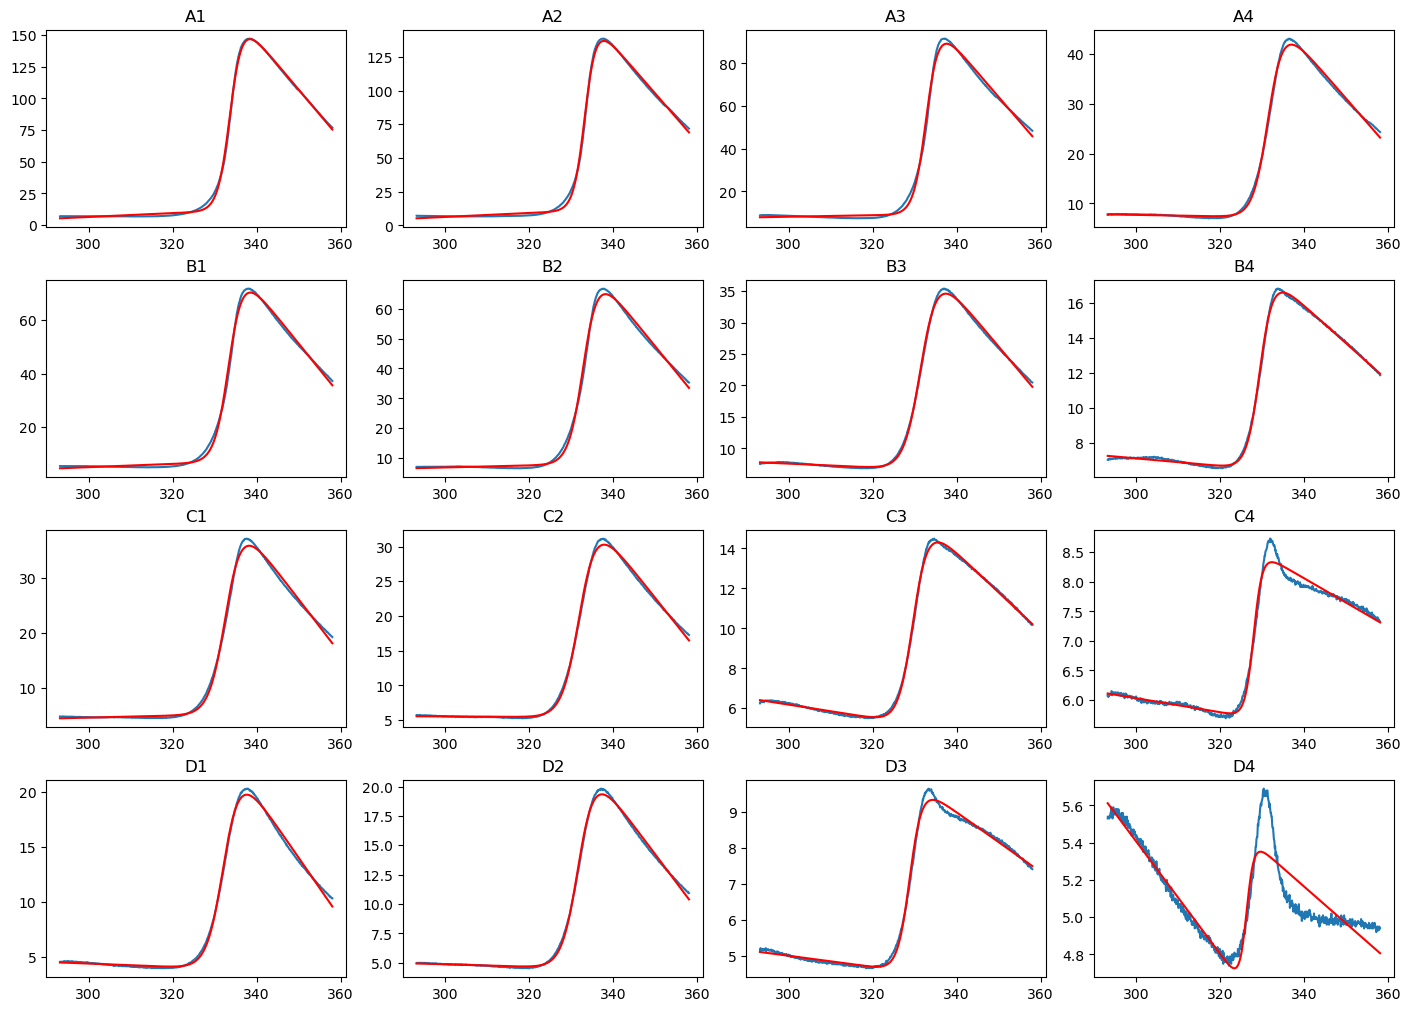

  SamplePos          Tm     Error
0        A1  333.812832  0.012452
0        A2  333.365094  0.014226
0        A3  332.896370  0.021205
0        A4  331.564137  0.018647
0        B1  333.540712  0.021271
0        B2  333.053548  0.022692
0        B3  331.686003  0.015675
0        B4  329.483934  0.013724
0        C1  332.858759  0.024700
0        C2  332.166180  0.018651
0        C3  329.744508  0.014210
0        C4  327.951536  0.032072
0        D1  332.359852  0.021023
0        D2  331.910076  0.017261
0        D3  328.908492  0.023433
0        D4  326.209046  0.099373


In [33]:
dfObj = pd.DataFrame(columns=['SamplePos', 'Tm', 'Error'])

fig = plt.figure(figsize=(14,10), constrained_layout=True)
gs1 = fig.add_gridspec(4, 4)
axs = []

for i, num in zip(['A1','A2','A3','A4','B1','B2','B3','B4','C1','C2','C3','C4','D1','D2','D3','D4'], range(1,17)):
    
    x=dict_of_wells[i]['Temp'] + 273.15 # convert from °C to °K 
    y=dict_of_wells[i]['465-580']
    
    params, params_covariance = curve_fit(funcUFnoDCp, x, y,[6, -0.01, 150, 0.02, 402000, 330], maxfev=10000) # initial guess for curve_fit - this might not be a good estimate for each condition!
    
    dfAdd = pd.DataFrame({'SamplePos': [i], 'Tm': [params[5]], 'Error': [np.sqrt(np.diag(params_covariance))[5]]})
    
    dfObj = pd.concat((dfObj, dfAdd), axis = 0)
        
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].plot(dict_of_wells[i]['Temp'] + 273.15, dict_of_wells[i]['465-580'])
    axs[-1].plot(x, funcUFnoDCp(x, *params), color="red",label='Fit')
    axs[-1].set_title(i)

plt.show()
print(dfObj)

We can see that wells C4, D3, and D4 - those wells with low amounts of protein and high amount of dye - do not give the expected, characteristic signal and, consequently, cannot be fitted nicely.

We can see that wells A4, B3, B4, C1, C2, C3, D1, and D2 do give the expected characteristic signal, but the overall fluorescence change is small (from 0 to <50).

We can conclude that the experimental conditions in wells A1, A2, A3, B1, and B2 are suitable. However, based on the overall fluorescence change, I am more inclined to choose the conditions of A1.